In [1]:
%load_ext autoreload
%autoreload 2

import os

subj = "Subj2"

match subj:
    case 'Subj1':
        N_STAGES = 9
    case 'Subj2':
        N_STAGES = 8
    case 'Subj3':
        N_STAGES = 10
        
UNIQUE_VALUES_THRESHOLD = 200

exp = "exp_reduced_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

In [2]:
import typing

import mne
import numpy
import pandas
import IPython.display
import sklearn.metrics
import matplotlib.colors
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.pyplot as plt

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

### Data

Opening raw data file Subj2/src/data_rr_filt-raw.fif...
    Range : 4000 ... 1176000 =      8.000 ...  2352.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj2\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
2019 matching events found
No baseline correction applied
0 projection items activated
No projector specified for this dataset. Please consider the method self.add_proj.


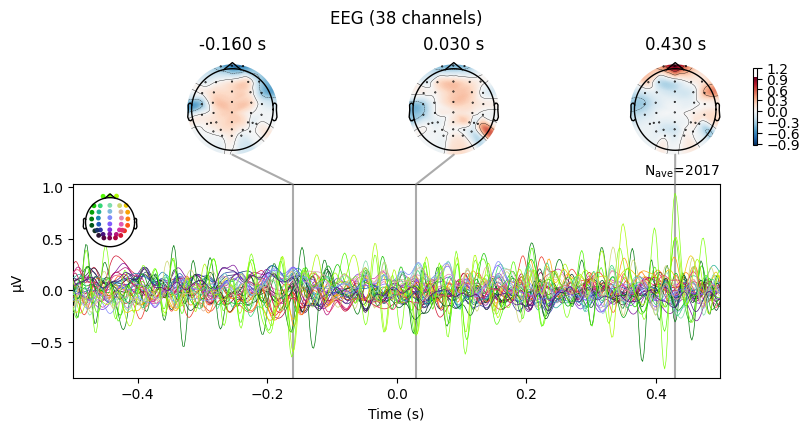

In [3]:
raw_data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif").drop_channels(ch_names = [ "A1", "A2" ])
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ "A1", "A2" ])
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]

epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)

### Features

In [4]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder, reduced = True)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder, reduced = True)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder, reduced = True)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from Subj2/exp_reduced_flow/features/per_channel/features.feather
Got features from Subj2/exp_reduced_flow/features/overall/features.feather


,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,0.000001,7.044258e-08,2.328848e-07,0.000007,0.000007,0.000002,4.336775e-07,1.093763e-08,5.483172e-08,1.093763e-06,...,0.000006,0.001489,0.001489,0.000283,0.000058,0.000053,0.000003,0.000320,0.000320,0.000131
1,0.000001,6.927574e-08,2.585724e-07,0.000007,0.000007,0.000003,6.509595e-07,1.863304e-08,9.962284e-08,1.863304e-06,...,0.000008,0.004758,0.004758,0.000536,0.000077,0.000059,0.000004,0.001942,0.001942,0.000339
2,0.000002,8.817767e-08,2.979744e-07,0.000009,0.000009,0.000003,5.441021e-07,1.412946e-08,7.359729e-08,1.412946e-06,...,0.000007,0.004127,0.004127,0.000497,0.000069,0.000060,0.000004,0.001315,0.001315,0.000281
3,0.000001,8.217518e-08,2.489177e-07,0.000008,0.000008,0.000003,3.238418e-07,7.539524e-09,4.258739e-08,7.539524e-07,...,0.000003,0.002478,0.002478,0.000408,0.000077,0.000070,0.000004,0.000976,0.000976,0.000261
4,0.000001,8.372699e-08,2.707279e-07,0.000008,0.000008,0.000003,5.503490e-07,1.452637e-08,7.787989e-08,1.452637e-06,...,0.000008,0.002102,0.002102,0.000369,0.000079,0.000070,0.000007,0.000489,0.000489,0.000186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.000002,1.873553e-07,4.932689e-07,0.000019,0.000019,0.000005,8.208257e-07,4.607151e-08,1.518776e-07,4.607151e-06,...,0.000004,0.005779,0.005779,0.000687,0.000093,0.000087,0.000004,0.003823,0.003823,0.000577
2013,0.000002,1.747820e-07,4.652974e-07,0.000017,0.000017,0.000005,1.096376e-06,3.906440e-08,1.588440e-07,3.906440e-06,...,0.000007,0.007868,0.007868,0.000866,0.000111,0.000101,0.000006,0.002725,0.002725,0.000525
2014,0.000003,1.728739e-07,5.258060e-07,0.000017,0.000017,0.000006,1.034737e-06,6.357581e-08,2.082659e-07,6.357581e-06,...,0.000004,0.006874,0.006874,0.000755,0.000093,0.000086,0.000003,0.003027,0.003027,0.000512
2015,0.000003,3.701761e-07,7.853103e-07,0.000037,0.000037,0.000009,1.162943e-06,7.769330e-08,2.248054e-07,7.769330e-06,...,0.000014,0.004074,0.004074,0.000628,0.000120,0.000103,0.000014,0.000620,0.000620,0.000256


In [5]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,-1.407105,-1.014873,-1.211216,-1.014873,-1.014873,-1.180028,-0.947355,-0.858969,-0.989625,-0.858969,...,-0.539667,-1.607316,-1.607316,-2.116040,-2.046518,-2.196665,-0.677391,-1.161069,-1.161069,-1.683220
1,-1.222804,-1.025757,-1.080708,-1.025757,-1.025757,-1.070148,-0.461953,-0.590624,-0.432934,-0.590624,...,-0.056724,-0.164437,-0.164437,-0.659097,-1.153492,-1.871891,-0.528299,-0.004338,-0.004338,-0.372904
2,-0.627370,-0.849455,-0.880522,-0.849455,-0.849455,-0.876145,-0.700669,-0.747668,-0.756395,-0.747668,...,-0.245847,-0.443192,-0.443192,-0.888038,-1.537672,-1.818778,-0.646479,-0.451729,-0.451729,-0.738976
3,-1.224408,-0.905442,-1.129759,-0.905442,-0.905442,-1.095202,-1.192724,-0.977464,-1.141805,-0.977464,...,-1.253882,-1.171044,-1.171044,-1.399442,-1.168469,-1.236203,-0.628103,-0.693403,-0.693403,-0.862766
4,-1.354984,-0.890968,-1.018950,-0.890968,-0.890968,-0.999462,-0.686714,-0.733827,-0.703168,-0.733827,...,0.037869,-1.336954,-1.336954,-1.622821,-1.074185,-1.224264,0.081471,-1.040261,-1.040261,-1.336682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,-0.033020,0.075590,0.111688,0.075590,0.075590,0.101186,-0.082477,0.366177,0.216520,0.366177,...,-1.005159,0.286224,0.286224,0.204467,-0.421667,-0.228154,-0.606584,1.336991,1.336991,1.125853
2013,-0.215888,-0.041683,-0.030423,-0.041683,-0.041683,-0.036736,0.533094,0.121834,0.303103,0.121834,...,-0.209088,1.208120,1.208120,1.236105,0.466930,0.594249,-0.161130,0.553799,0.553799,0.800784
2014,0.546607,-0.059480,0.276996,-0.059480,-0.059480,0.217635,0.395396,0.976567,0.917349,0.976567,...,-0.971265,0.769284,0.769284,0.599593,-0.419594,-0.251224,-0.774080,0.769550,0.769550,0.717214
2015,1.641688,1.780790,1.595431,1.780790,1.780790,1.635564,0.681802,1.468855,1.122912,1.468855,...,1.439362,-0.466559,-0.466559,-0.132724,0.898600,0.740415,1.554958,-0.946717,-0.946717,-0.897191


### Feature selection

In [6]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 15,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = 1500,
    min_unique_values = UNIQUE_VALUES_THRESHOLD
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
numpy.save(f"{subj}/{exp}/qsda/best_features.npy", features.to_numpy())
display(best_features)
display(scores)

scores: 100%|██████████| 4644/4644 [4:30:18<00:00,  3.49s/it]  

Using threshold 0.31


,channel-0 amplitude-landscape-1-1 norm-2,channel-0 amplitude-landscape-1-2 norm-1,channel-0 amplitude-landscape-2-2 dim-1,channel-0 amplitude-silhouette-1-1 norm-2,channel-0 life dim-1 mean,channel-0 bd2 all mean,channel-0 bd2 all norm-2,channel-0 bd2 dim-1 mean,channel-0 bd2 dim-1 norm-2,channel-0 bd2 dim-2 mean,...,channel-37 amplitude-silhouette-2-2 norm-2,channel-37 life all max,channel-37 life all std,channel-37 life dim-1 max,channel-37 life dim-1 std,channel-37 bd2 all max,channel-37 bd2 all std,channel-37 bd2 dim-1 std,channel-37 bd2 dim-2 std,overall bd2 dim-3 mean
0,-1.025214,-1.104486,-1.238791,-1.117181,-1.282539,-1.497418,-1.449001,-1.488609,-1.479374,-1.532271,...,-0.250692,-0.212437,-0.402905,-0.212131,-0.370953,-0.162415,0.381860,0.563037,0.229829,-2.196665
1,-1.024904,-0.971054,-0.999150,-0.752462,-0.798981,-1.153969,-1.121208,-1.112843,-0.969842,-1.063624,...,0.204521,0.895952,0.662948,0.896178,0.731393,1.865302,2.158819,1.807138,2.960060,-1.871891
2,-0.860254,-0.863632,-0.855654,-0.886046,-1.262186,-1.334247,-1.105631,-1.295295,-1.084362,-1.455276,...,-0.363129,-0.647079,-0.766766,-0.646742,-0.767196,0.148336,0.568299,0.920136,-0.167179,-1.818778
3,-0.920738,-0.995465,-1.128158,-1.121915,-1.419562,-1.300981,-1.203397,-1.231195,-1.031904,-1.401734,...,-0.209865,-0.430272,-0.132072,-0.429951,-0.109161,-0.182146,-0.691333,-0.951648,-0.844091,-1.236203
4,-0.900315,-0.994010,-1.057674,-0.852344,-1.074826,-1.117814,-1.194714,-1.131657,-1.221356,-1.050778,...,-0.112981,0.157286,-0.023505,0.157565,-0.004774,0.502644,1.004638,0.932158,1.384454,-1.224264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.081913,0.198170,0.152826,-0.067068,0.410923,0.312322,0.220744,0.314552,0.138643,0.180505,...,-0.366293,-0.684291,-0.850498,-0.683951,-0.843206,-0.801118,-0.871675,-0.889732,-0.671245,-0.228154
2013,-0.042340,-0.024370,0.017645,0.046922,0.132301,0.431767,0.097846,0.497289,0.257170,0.337601,...,-0.287975,-0.194198,0.159899,-0.193894,0.099520,1.590283,1.506744,1.703811,1.058427,0.594249
2014,-0.011835,0.125853,0.225748,0.260832,0.687587,0.504161,0.604719,0.474685,0.634806,0.715516,...,-0.331277,-0.912120,-0.882228,-0.911764,-0.882151,-0.711192,-1.036077,-0.991953,-1.035479,-0.251224
2015,1.779580,2.047109,1.644535,0.985681,1.784639,1.625706,1.873415,1.433879,1.752317,2.431229,...,-0.178564,-0.029703,-0.132716,-0.029411,-0.115471,1.285267,1.237591,1.559962,0.320972,0.740415


,name,score,mean,variance,unique_values,normalized_score
0,channel-0 landscape dim-1 max,1.010298,-1.550019e-16,1.0,2017,0.213564
1,channel-0 landscape dim-1 mean,1.310240,-4.227324e-17,1.0,2017,0.282525
2,channel-0 landscape dim-1 std,1.314854,9.863756e-17,1.0,2017,0.283585
3,channel-0 landscape dim-1 sum,1.310240,9.863756e-17,1.0,2017,0.282525
4,channel-0 landscape dim-1 norm-1,1.310240,9.863756e-17,1.0,2017,0.282525
...,...,...,...,...,...,...
4639,overall bd2 dim-3 mean,1.471759,-2.677305e-16,1.0,2013,0.319660
4640,overall bd2 dim-3 std,0.442976,1.056831e-16,1.0,1997,0.083130
4641,overall bd2 dim-3 sum,0.264090,-6.340986e-17,1.0,2013,0.042002
4642,overall bd2 dim-3 norm-1,0.264090,-6.340986e-17,1.0,2013,0.042002


### Results

#### Estimator

In [22]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    print(all_features.shape)
    numpy.save(f"{folder}/all_features.npy", all_features)
    numpy.savetxt(f"{folder}/all_features_shape.txt", all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    numpy.save(f"{folder}/pca_features.npy", pca_features)
    numpy.savetxt(f"{folder}/pca_features_shape.txt", pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.savetxt(f"{folder}/explained_variance.txt", [ pca.explained_variance_ratio_.sum() ])
    numpy.savetxt(f"{folder}/explained_variance_ratios.txt", pca.explained_variance_ratio_)

    # SDA
    sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_eeg_stages(raw_data, best_edges, epochs).savefig(f"{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(2017, 765)
(2017, 15)
Explained variance 0.6
[0.17, 0.092, 0.084, 0.057, 0.033, 0.025, 0.024, 0.02, 0.018, 0.016, 0.015, 0.012, 0.012, 0.011, 0.01]
Applying to 2017 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:22<00:00, 30.33it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,0,40,20,Mode,40,"[0, 370, 526, 906, 1052, 1275, 1489, 1857, 2017]",8,380,146,252.125,19567.209896,12.825887,0.034544,139.666913,3.542148,0.109779,65.016172,2.852257


array([   0,  370,  526,  906, 1052, 1275, 1489, 1857, 2017])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(10.5, 434.5)","(436.5, 618.5)","(619.5, 1069.5)","(1071.5, 1240.5)","(1242.5, 1502.5)","(1503.5, 1750.5)","(1752.5, 2169.5)","(2170.5, 2345.5)"
"Time length, sec",424.0,182.0,450.0,169.0,260.0,247.0,417.0,175.0
Number of epochs,370,156,380,146,223,214,368,160


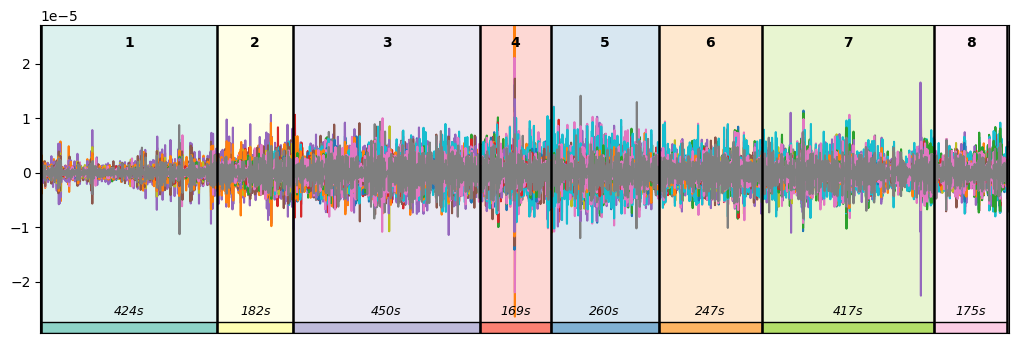

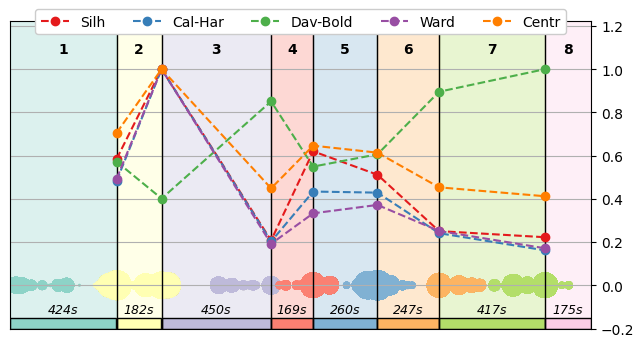

In [23]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result[:-2]
    return result

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + QSDA + PCA

(2017, 1521)
(2017, 15)
Explained variance 0.58
[0.108, 0.052, 0.043, 0.04, 0.037, 0.034, 0.033, 0.032, 0.032, 0.03, 0.028, 0.028, 0.027, 0.026, 0.025]
Applying to 2017 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:22<00:00, 30.48it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,40,45,15,Median,40,"[0, 372, 545, 620, 994, 1125, 1275, 1746, 2017]",8,471,75,252.125,14532.603952,12.652824,-0.104554,37.775894,4.798023,0.135397,20.508392,4.33591


array([   0,  372,  545,  620,  994, 1125, 1275, 1746, 2017])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(10.5, 437.5)","(438.5, 641.5)","(642.5, 732.5)","(733.5, 1170.5)","(1171.5, 1333.5)","(1334.5, 1502.5)","(1503.5, 2044.5)","(2045.5, 2345.5)"
"Time length, sec",427.0,203.0,90.0,437.0,162.0,168.0,541.0,300.0
Number of epochs,372,173,75,374,131,150,471,271


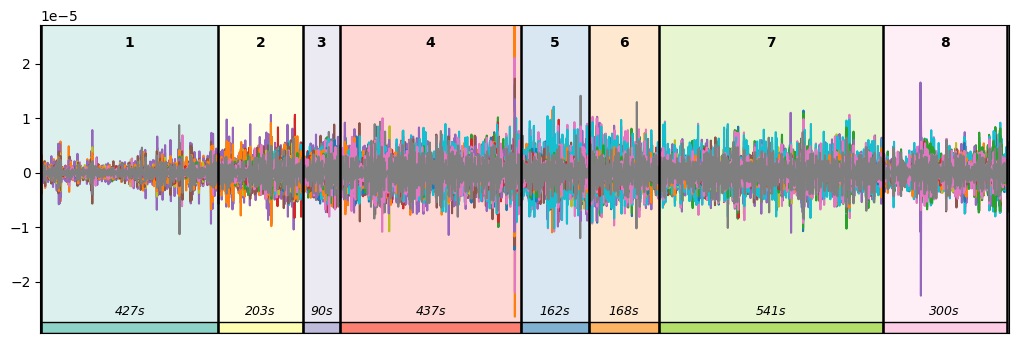

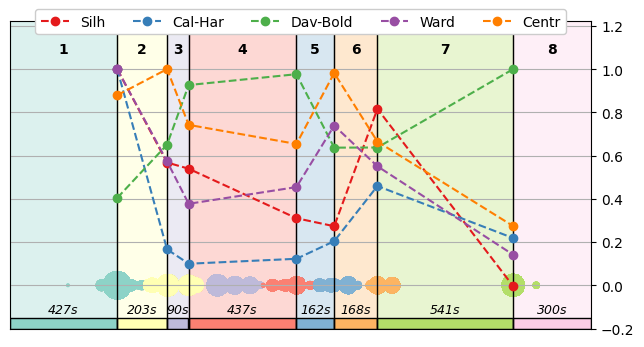

In [24]:
analyze(best_features, 15, "best_topological")

#### Традиционные и топологические вместе + PCA

(2017, 2286)
(2017, 15)
Explained variance 0.48
[0.107, 0.057, 0.044, 0.037, 0.027, 0.026, 0.023, 0.023, 0.022, 0.021, 0.02, 0.02, 0.019, 0.018, 0.018]
Applying to 2017 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:21<00:00, 31.40it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,0,40,10,Mode,40,"[0, 372, 567, 646, 994, 1123, 1275, 1788, 2017]",8,513,79,252.125,27721.835951,17.191484,-0.006651,78.194319,3.851324,0.140518,34.350084,3.511226


array([   0,  372,  567,  646,  994, 1123, 1275, 1788, 2017])

,0,1,2,3,4,5,6,7
"Start-end time, sec","(10.5, 437.5)","(438.5, 666.5)","(668.5, 762.5)","(763.5, 1170.5)","(1171.5, 1330.5)","(1332.5, 1502.5)","(1503.5, 2094.5)","(2095.5, 2345.5)"
"Time length, sec",427.0,228.0,94.0,407.0,159.0,170.0,591.0,250.0
Number of epochs,372,195,79,348,129,152,513,229


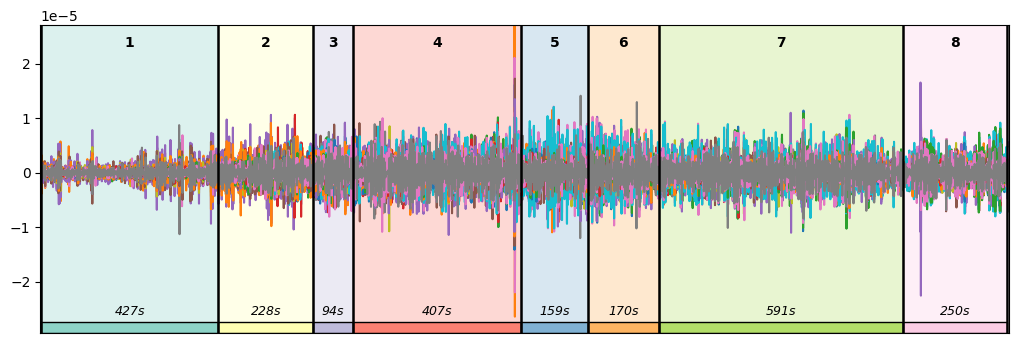

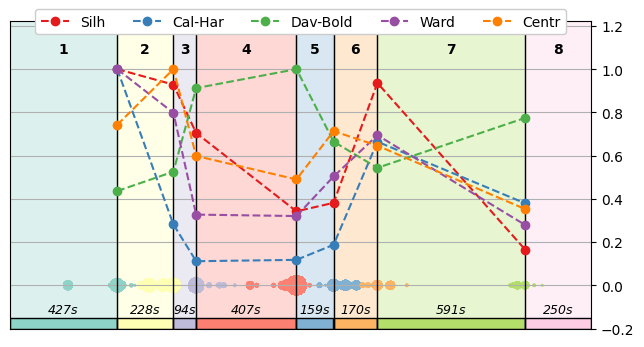

In [25]:
combined_features = pandas.concat([ read_traditional(), best_features ], axis = 1)
analyze(combined_features, 15, "combined")

### Information value

In [26]:
result_edges = numpy.loadtxt(f"{subj}/{exp}/results/best_topological/best_edges.txt").astype(numpy.int32)
print(result_edges)

if os.path.exists(f"{subj}/{exp}/IV/IV.csv"):
    ivs = pandas.read_csv(f"{subj}/{exp}/IV/IV.csv")
else:
    _, labels = SDA.stageprocess.form_stage_bands(result_edges)
    ivs = SDA.analytics.IV.calc_IV_clust(features, labels)

    os.makedirs(f"{subj}/{exp}/IV", exist_ok = True)
    ivs.to_csv(f"{subj}/{exp}/IV/IV.csv", index = False)

ivs["normalized_iv"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ivs[["IV"]])
display(ivs)

[   0  372  545  620  994 1125 1275 1746 2017]


,Feature,IV,IVs,normalized_iv
0,channel-0 landscape dim-1 max,0.588851,"[1.7063926525919524, 0.6980680995830355, 0.124...",0.518795
1,channel-0 landscape dim-1 mean,0.746501,"[2.105255549596962, 1.0567029640609835, 0.1379...",0.668273
2,channel-0 landscape dim-1 std,0.756276,"[2.269436965652904, 0.9492863827825737, 0.1424...",0.677541
3,channel-0 landscape dim-1 sum,0.746501,"[2.105255549596962, 1.0567029640609835, 0.1379...",0.668273
4,channel-0 landscape dim-1 norm-1,0.746501,"[2.105255549596962, 1.0567029640609835, 0.1379...",0.668273
...,...,...,...,...
4639,overall bd2 dim-3 mean,0.986125,"[3.005275932026282, 0.22502280470912817, 0.608...",0.895475
4640,overall bd2 dim-3 std,0.256037,"[0.8786292672673128, 0.05333733977642844, 0.25...",0.203232
4641,overall bd2 dim-3 sum,0.138609,"[0.02067839329937159, 0.20289938839043853, 0.1...",0.091892
4642,overall bd2 dim-3 norm-1,0.138609,"[0.02067839329937159, 0.20289938839043853, 0.1...",0.091892


In [27]:
iv_qsda_scores = scores.join(ivs, lsuffix = "name", rsuffix = "Feature")
iv_qsda_scores = iv_qsda_scores[["name", "unique_values", "score", "normalized_score", "IV", "normalized_iv"]]

iv_qsda_scores["score"] = iv_qsda_scores["score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)
iv_qsda_scores["normalized_score"] = iv_qsda_scores["normalized_score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'score', ascending = False)
iv_qsda_scores["QSDA_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'IV', ascending = False)
iv_qsda_scores["IV_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores["IDX_DIFF"] = iv_qsda_scores["QSDA_IDX"] - iv_qsda_scores["IV_IDX"]

iv_qsda_scores = iv_qsda_scores.sort_index()
display(iv_qsda_scores)

,name,unique_values,score,normalized_score,IV,normalized_iv,QSDA_IDX,IV_IDX,IDX_DIFF
0,channel-0 landscape dim-1 max,2017,1.010298,0.213564,0.588851,0.518795,2242,227,2015
1,channel-0 landscape dim-1 mean,2017,1.310240,0.282525,0.746501,0.668273,1673,74,1599
2,channel-0 landscape dim-1 std,2017,1.314854,0.283585,0.756276,0.677541,1663,63,1600
3,channel-0 landscape dim-1 sum,2017,1.310240,0.282525,0.746501,0.668273,1676,72,1604
4,channel-0 landscape dim-1 norm-1,2017,1.310240,0.282525,0.746501,0.668273,1675,75,1600
...,...,...,...,...,...,...,...,...,...
4639,overall bd2 dim-3 mean,2013,1.471759,0.319660,0.986125,0.895475,1469,7,1462
4640,overall bd2 dim-3 std,1997,0.442976,0.083130,0.256037,0.203232,3937,1758,2179
4641,overall bd2 dim-3 sum,2013,0.264090,0.042002,0.138609,0.091892,4472,3424,1048
4642,overall bd2 dim-3 norm-1,2013,0.264090,0.042002,0.138609,0.091892,4473,3423,1050


<Axes: >

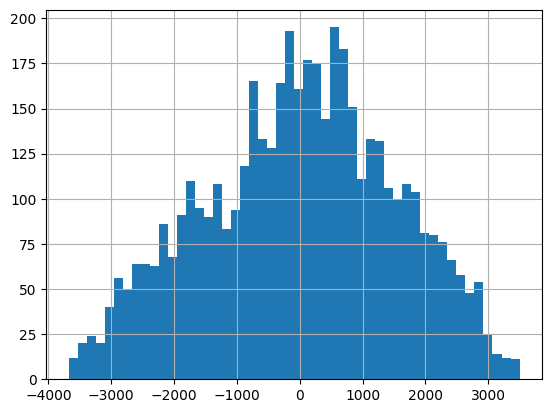

In [28]:
iv_qsda_scores["IDX_DIFF"].hist(bins = 50)

In [29]:
def vec_div(vec):
    mat1 = numpy.repeat(vec.reshape(-1, 1), repeats = len(vec), axis = 1)
    mat2 = numpy.repeat(vec.reshape(1, -1), repeats = len(vec), axis = 0)
    return numpy.sign(mat1 - mat2)

qsda = vec_div(iv_qsda_scores["score"].to_numpy())
iv = vec_div(iv_qsda_scores["IV"].to_numpy())

correct = ((qsda == iv).sum() - iv_qsda_scores.shape[0]) / 2
incorrect = ((qsda != iv).sum() - iv_qsda_scores.shape[0]) / 2

print(correct / 1e6, incorrect / 1e6)

6.617504 4.16122


In [30]:
def sourceFilter(row):
    if row['Source'].startswith('dissim'):
        return 'dissim'
    return row['Source']

iv_qsda_scores[["Source", "Algorithm", "Dimension", "Stat"]] = iv_qsda_scores['name'].str.split(' ', expand = True)
iv_qsda_scores["Source"] = iv_qsda_scores.apply(sourceFilter, axis = 1)
iv_qsda_scores.to_csv(f"{subj}/{exp}/IV/iv_qsda_scores.csv", index = False)

In [31]:
def SourceRenamer(initial: str) -> str:
    if initial == 'dissim':
        return 'Correlations analysis'
    if initial == 'overall':
        return 'Overall processing'
    ind = initial.find('-') + 1
    comp = int(initial[ind:])
    return f'Comp. {comp} (ch. {epochs.ch_names[comp]})'

def AlgorithmRenamer(row):
    return {
        'amplitude-betti-1':        'Betti amp. with p=1',
        'amplitude-betti-2':        'Betti amp. with p=2',

        'amplitude-bottleneck':     'Bottleneck amp.',
        'amplitude-wasserstein-1':  'Wasserstein amp. with p=1',
        'amplitude-wasserstein-2':  'Wasserstein amp. with p=2',
        
        'amplitude-landscape-1-1':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-1-2':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-2-1':  'Pers. landscape amp. with p=2',
        'amplitude-landscape-2-2':  'Pers. landscape amp. with p=2',
        
        'amplitude-silhouette-1-1': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-1-2': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-2-1': 'Pers. silhouette amp. with p=2',
        'amplitude-silhouette-2-2': 'Pers. silhouette amp. with p=2',

        'bd2':                      'Stat. char. of (b + d) / 2',
        'life':                     'Stat. char. of lifetimes',
        'betti':                    'Stat. char. of Betti curves',
        'landscape':                'Stat. char. of pers. landscape',
        'silhouette-1':             'Stat. char. of lvl 1 pers. silh.',
        'silhouette-2':             'Stat. char. of lvl 2 pers. silh.',
        
        'entropy':                  'Persistence entropy',
        'numberofpoints':           'Number of points',
    }[row]

def DimensionRenamer(row):
    return {
        'all':        'All',
        'dim-1':      'Dimension 1',
        'dim-2':      'Dimension 2',
        'dim-3':      'Dimension 3',
        'dim-4':      'Dimension 4',
        'dim-5':      'Dimension 5',
        'norm-1':     'Amplitude norm with p=1',
        'norm-2':     'Amplitude norm with p=2',
    }[row]

def StatRenamer(row):
    return {
        'kurtosis':      'Kurtosis',
        'skew':          'Skew',
        'max':           'Maximum',
        'mean':          'Mean',
        'median':        'Median',
        'norm-1':        'Norm with p=1',
        'norm-2':        'Norm with p=2',
        'percentile-25': 'Percentile - 25',
        'percentile-75': 'Percentile - 75',
        'std':           'Standard deviation',
        'sum':           'Sum',
    }[row]

def make_stats(data: pandas.DataFrame, group_by: str, sort_by: str):
    stats = data.groupby(by = group_by).mean(numeric_only = True)
    stats = stats.sort_values(by = sort_by).reset_index()
    stats.to_csv(f"{subj}/{exp}/IV/stats_{group_by}_{sort_by}.csv", index = False)
    return stats

def draw(
    data: pandas.DataFrame,
    group_by: str,
    sort_by: str,
    ax,
    renamer: typing.Callable[[str], str],
    title: str
):
    stats = make_stats(data, group_by, sort_by)
    stats[group_by] = stats[group_by].apply(renamer)
    stats.plot.barh(x = group_by, y = sort_by, ax = ax, xlim = (2 * stats[sort_by].min() / 3, None))

    ax.set_title(title)
    ax.get_legend().remove()
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

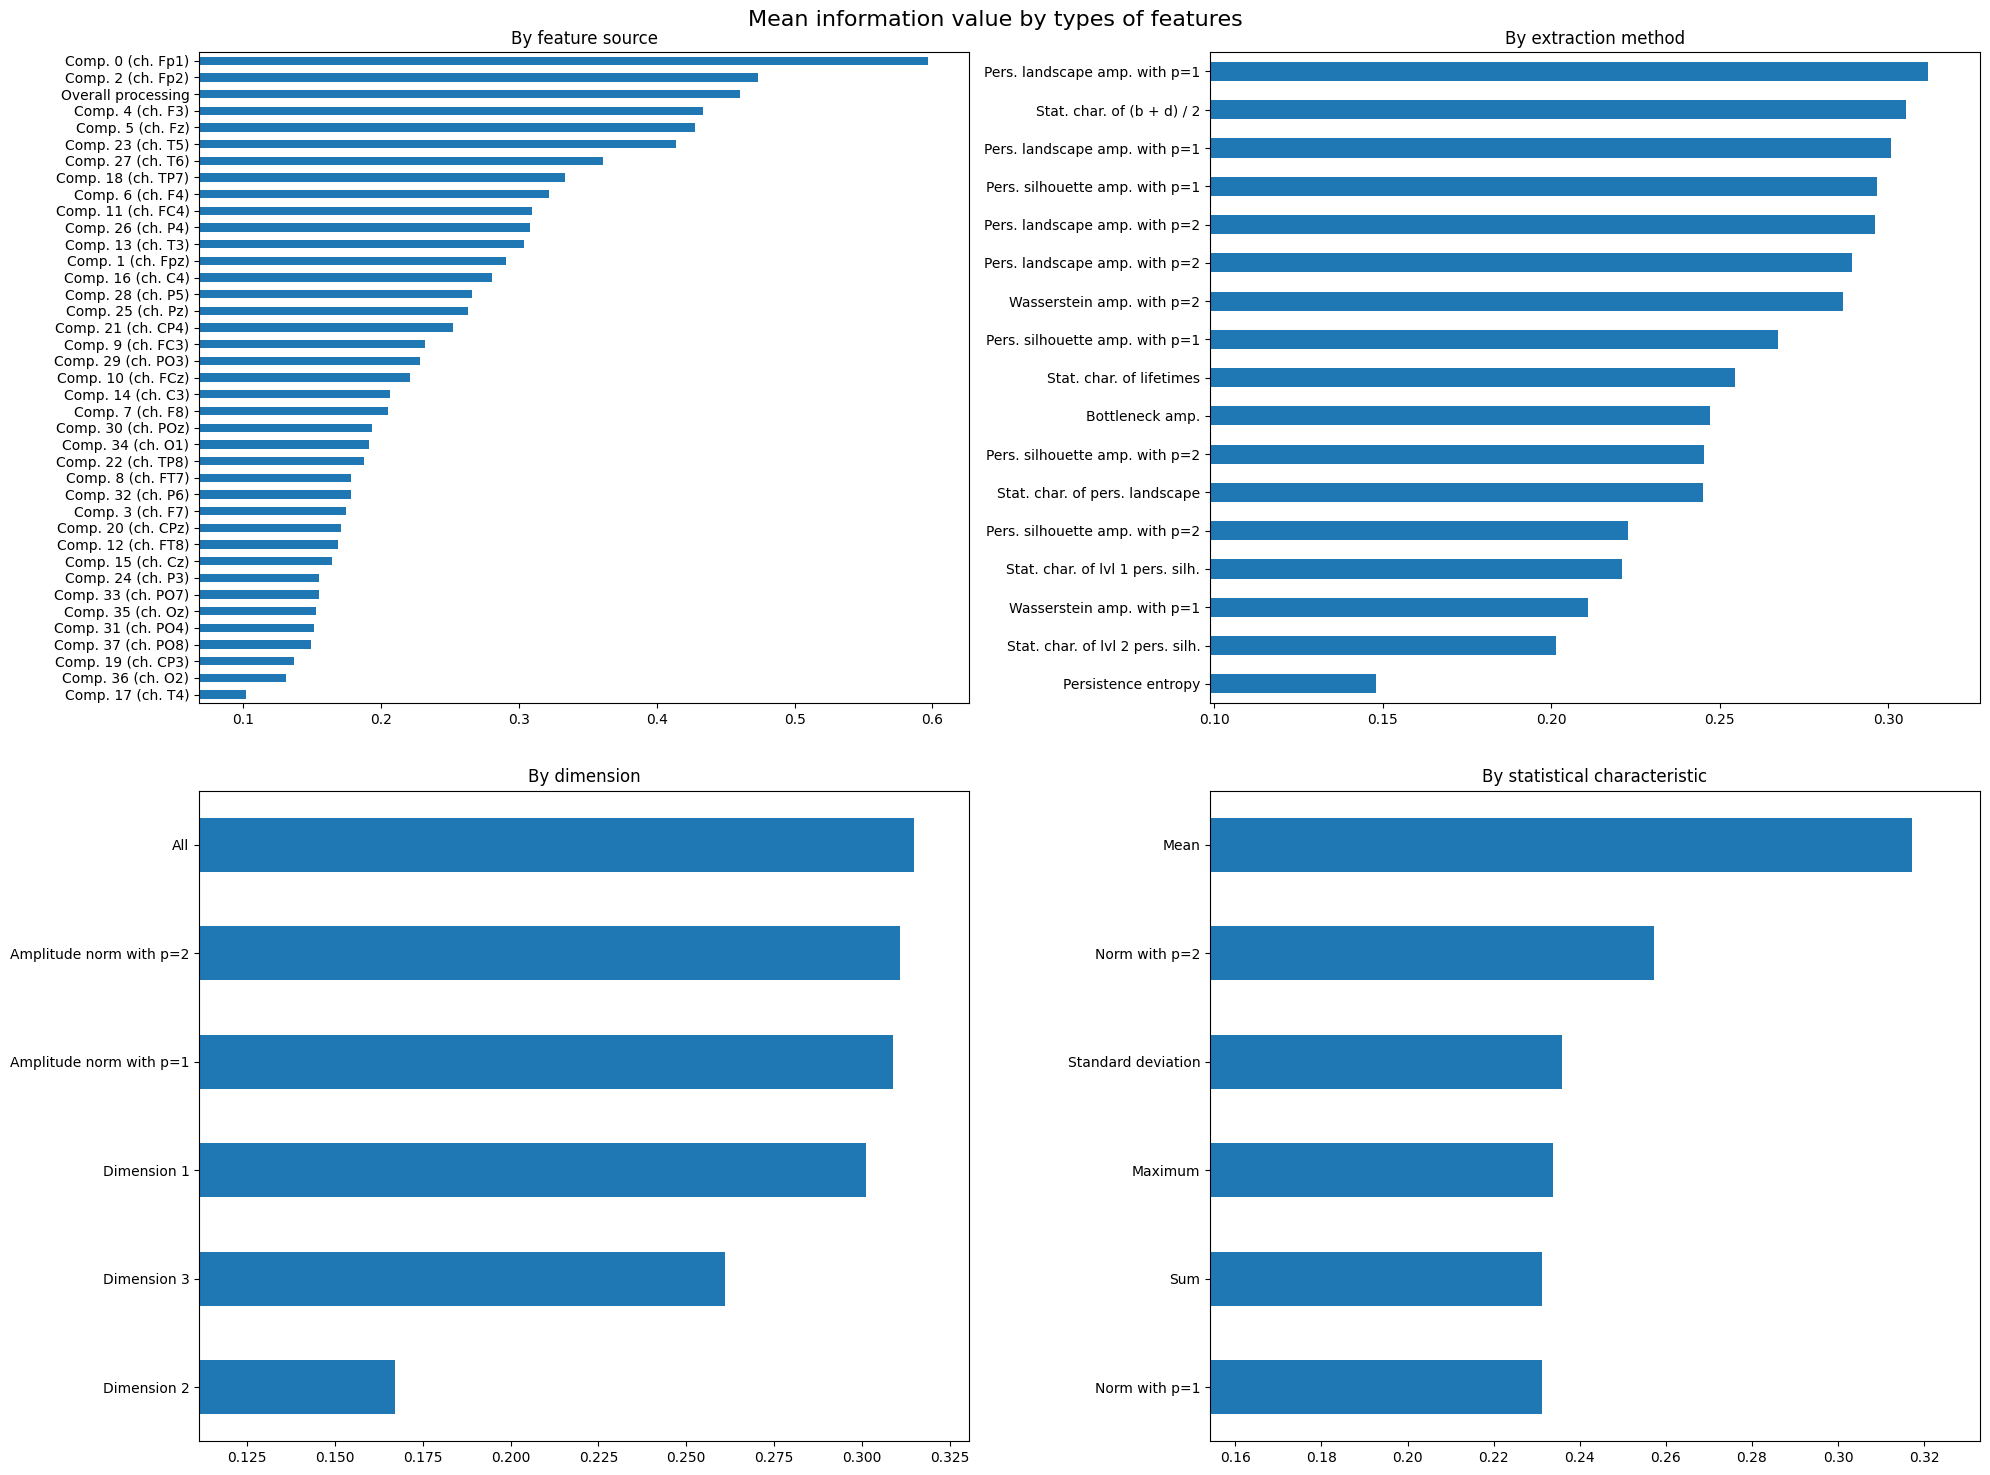

In [32]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean information value by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'IV', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'IV', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'IV', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'IV', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.png")

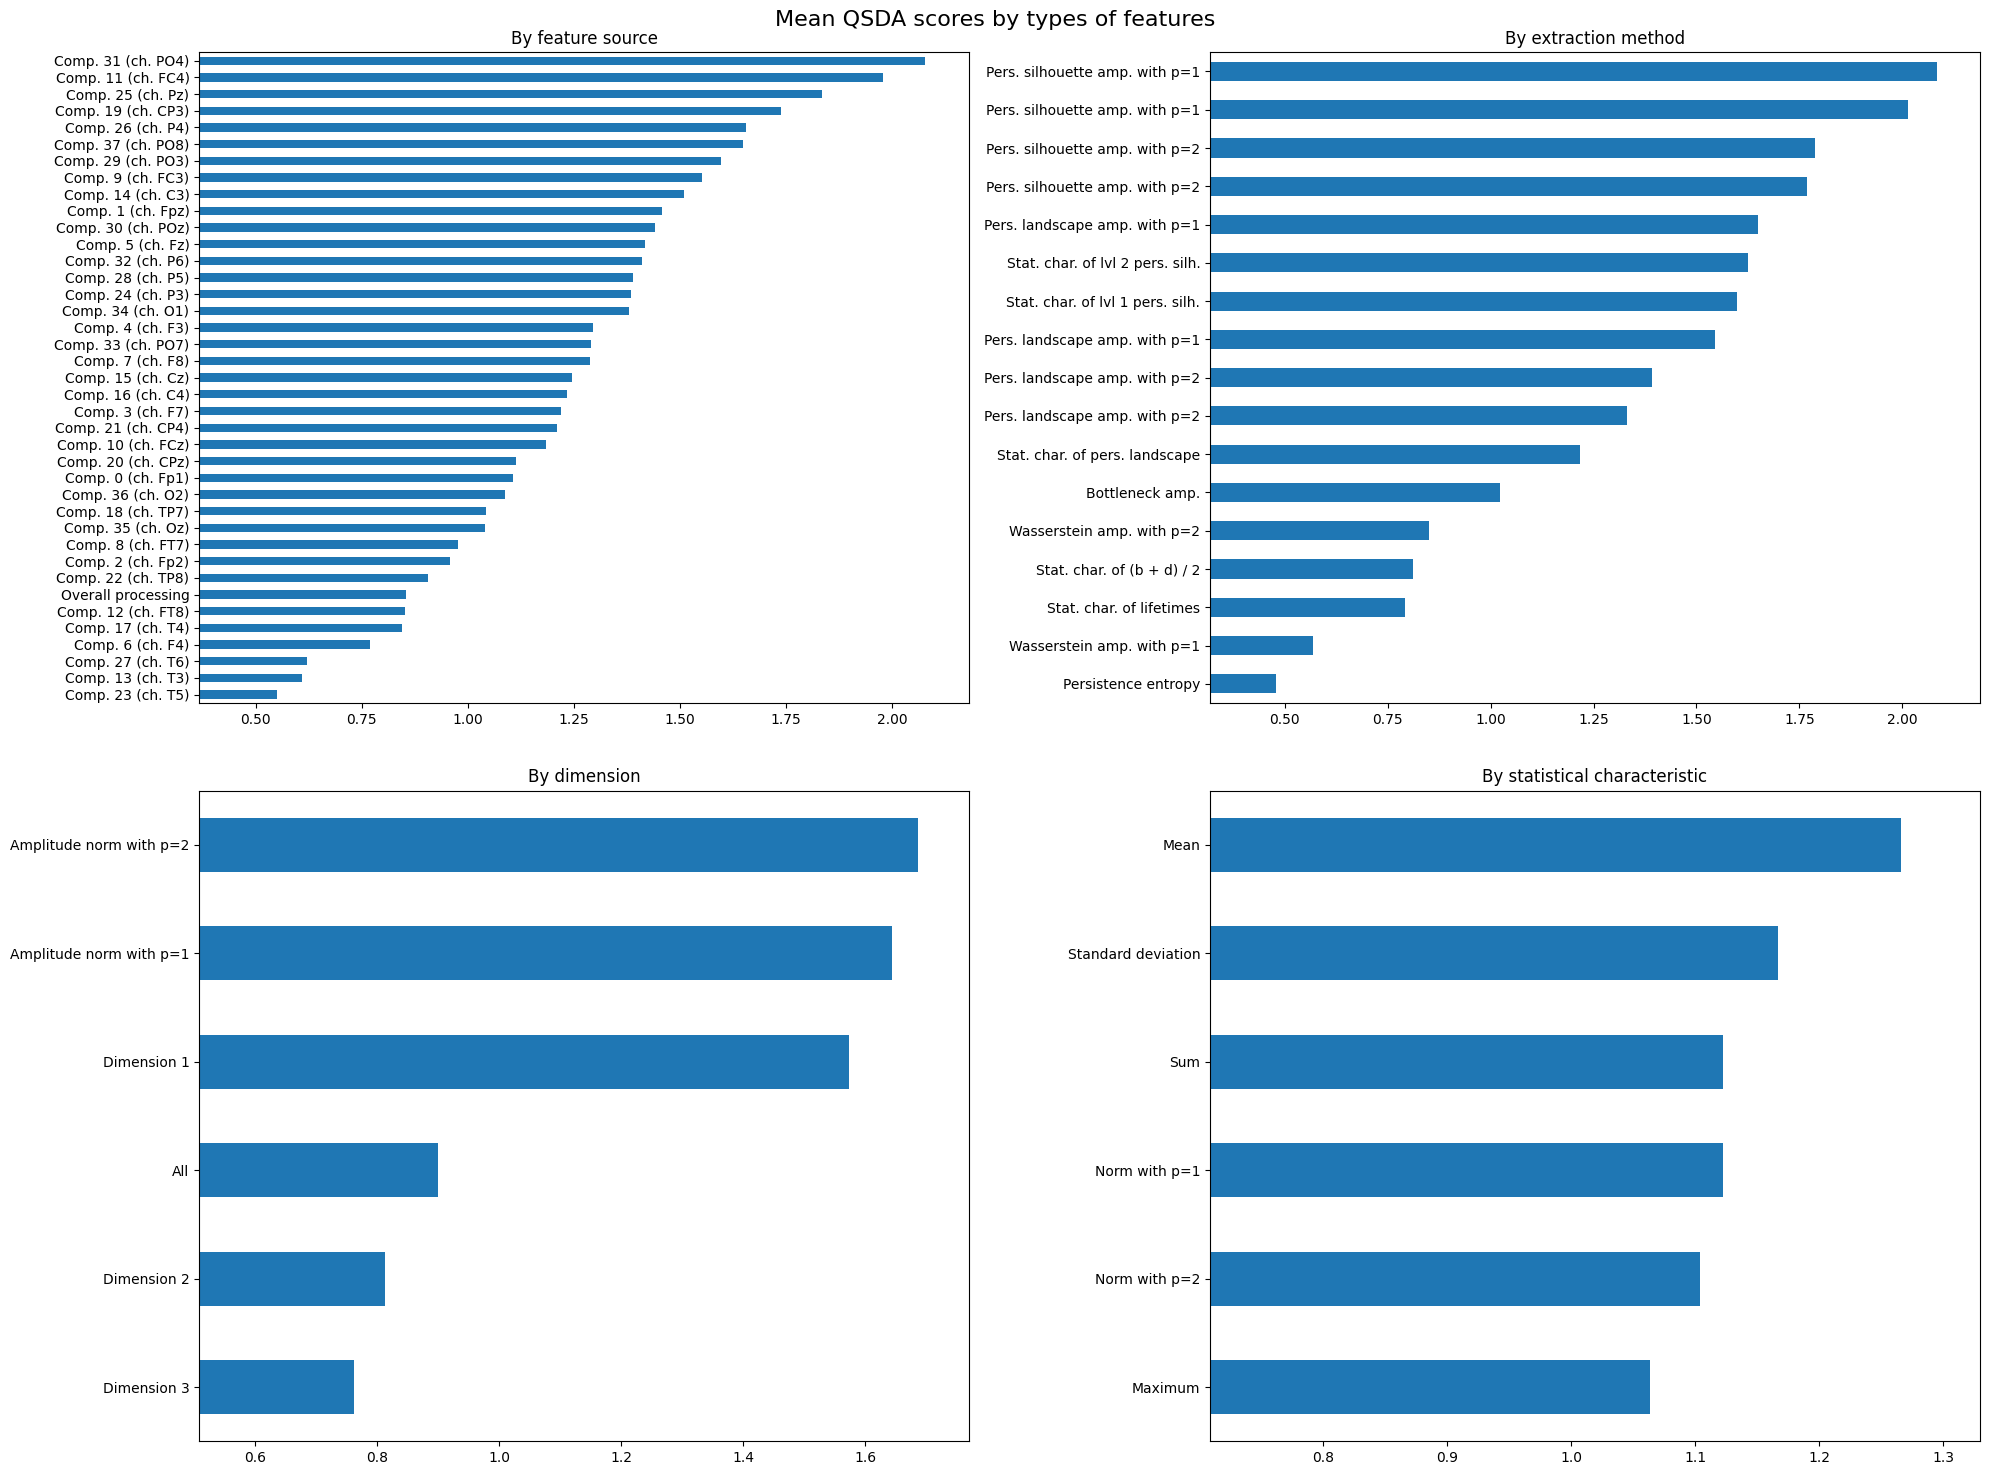

In [33]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean QSDA scores by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'score', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'score', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'score', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'score', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.png")

In [34]:
def draw_sources_heatmap(data: pandas.DataFrame, sort_by: str):
    svg = open("report/regions/regions.svg", "r").read()
    svg = svg[svg.find('>') + 1:svg.rfind('<') - 1]
    defs = ""

    stats = make_stats(data, "Source", sort_by)[["Source", sort_by]]
    stats = stats[stats.apply(lambda row: row['Source'].startswith('channel-'), axis = 1)]

    min, max = stats[sort_by].min(), stats[sort_by].max()
    colors = [[ 1, 0.25, 0 ], [ 1, 0.66, 0 ], [ 1, 0.75, 0 ], [ 0.66, 0.8, 0 ], [ 0.25, 1, 0 ]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rg', colors, N = int((max - min) * 1000))

    for _, row in stats.iterrows():
        score = int((row[sort_by] - min) * 1000)
        color = matplotlib.colors.rgb2hex(cmap(score))

        id = int(row['Source'][row['Source'].find('-') + 1:])
        id_index = svg.index(f'id="{id}"')
        path_start = svg.rfind("<", 0, id_index)
        path_end = svg.find(">", id_index)

        path = svg[path_start:path_end+1]
        m_idx = path.find("M")
        x = float(path[m_idx + 1:m_idx + 7])
        y = float(path[m_idx + 8:m_idx + 15])

        defs += f"""
            <radialGradient id="gradient{id}">
                <stop offset="0%" stop-color="{color}" stop-opacity="0.66"></stop>
                <stop offset="100%" stop-color="{color}" stop-opacity="0"></stop>
            </radialGradient>
        """
        part = f"""
            <circle cx="{x}" cy="{y - 2}" r="50" fill="url(#gradient{id})"></circle>
            {path.replace(f'id="{id}"', f'fill="{color}" stroke="{color}"')}
        """

        svg = svg[:path_start] + part + svg[path_end+1:]

    svg = f"""
        <svg viewBox="0 0 530 528" fill="none" xmlns="http://www.w3.org/2000/svg">
            <defs> {defs} </defs> {svg}
        </svg>
    """

    file = f"{subj}/{exp}/IV/{sort_by}_regions.svg"
    open(file, "w").write(svg)
    return IPython.display.SVG(file)

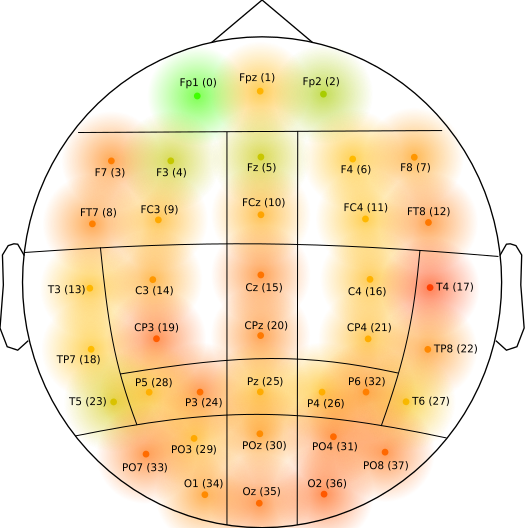

In [35]:
draw_sources_heatmap(iv_qsda_scores, "IV")

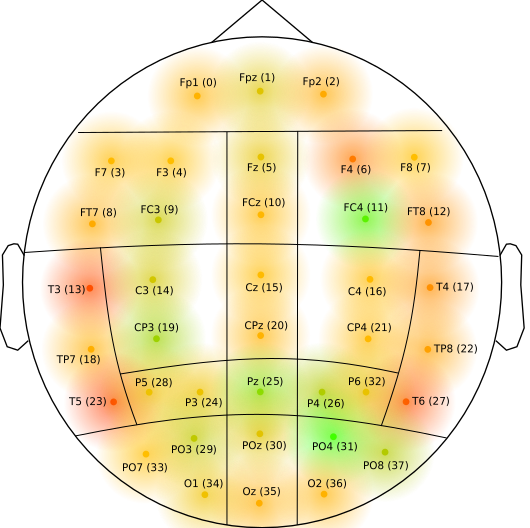

In [36]:
draw_sources_heatmap(iv_qsda_scores, "score")